## Import and Path Stuff

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import shutil

from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split

import keras
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.models import load_model

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tensorflow as tf 

from keras.applications.vgg16 import VGG16
from keras.models import Model

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter, defaultdict

import timeit
import pickle
import glob
from tqdm import tqdm

import cv2
from PIL import Image as pil

from statistics import mean

import json
from skimage.transform import resize

from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras import optimizers
from keras.layers.merge import concatenate

from random import randint

In [ ]:
jpg_image_path_folder = "/content/drive/MyDrive/Project_Related/train-jpg/train-jpg"

tif_image_path_folder = "/content/drive/MyDrive/Project_Related/train-tif-v2/train-tif-v2"

image_tags_path = "/content/drive/MyDrive/Project_Related/train_v2.csv"

save_data_path="/content/drive/MyDrive/processed_data_full.npz"

save_tif_data_path = "/content/drive/MyDrive/processed_data_full_for_tif.npz"

save_model_path = "/content/drive/MyDrive/"

save_history_path = "/content/drive/MyDrive/"

save_predictions_path = "/content/drive/MyDrive/"

## Making the Dataset

In [ ]:
def create_tag_mapping(tag_mapping_csv):
    all_tags = set()
    for i in range(len(tag_mapping_csv)):   
      tags = tag_mapping_csv['tags'][i].split(' ')   
      all_tags.update(tags)  
    all_tags = list(all_tags)
    all_tags.sort()
    tags_map = {all_tags[i]:i for i in range(len(all_tags))}
    inv_tags_map = {i:all_tags[i] for i in range(len(all_tags))}
    return tags_map, inv_tags_map

In [ ]:
filename = "/content/drive/MyDrive/Project_Related/train_v2.csv"
tag_mapping_csv = pd.read_csv(image_tags_path)
tags_map, inv_tags_map = create_tag_mapping(tag_mapping_csv)

In [ ]:
def get_tags_from_one_hot(op):
  op = list(op)
  res = []
  for i in range(len(op)):
    if op[i]==1:
      index_val = i
      res.append(inv_tags_map[index_val])
  return res

In [ ]:
def create_file_mapping(tag_mapping_csv):
    mapping = dict()
    for i in range(len(tag_mapping_csv)):  
      name, tags = tag_mapping_csv['image_name'][i], tag_mapping_csv['tags'][i]
      mapping[name] = tags.split(' ')       
    return mapping

In [ ]:
def one_hot_encode(tags, mapping):
    encoding = np.zeros(len(mapping), dtype='uint8')
    for tag in tags:
        encoding[mapping[tag]] = 1
    return encoding

In [ ]:
def get_image(name, form):
    if form == 'jpg':
        img = cv2.imread(jpg_image_path_folder+"/"+name+".jpg")
  
    elif form == 'tif':
        img = cv2.imread(tif_image_path_folder+"/"+name+".tif", flags=cv2.IMREAD_UNCHANGED)
        
    else:
        print('Image format must be jpg or tif')
    
    return img

In [ ]:
# load all images into memory
def make_dataset(path, file_mapping, tag_mapping, image_target_size=(128,128)):
    photos, targets = list(), list()

    for filename in tqdm(os.listdir(path)):

        photo = load_img(path + "/" + filename, target_size=image_target_size)

        photo = img_to_array(photo, dtype='uint8')

        tags = file_mapping[filename[:-4]]

        target = one_hot_encode(tags, tag_mapping)

        photos.append(photo)
        targets.append(target)
        
    X = np.asarray(photos, dtype='uint8')
    y = np.asarray(targets, dtype='uint8')
    
    return X, y

In [ ]:
def save_dataset_to_memory():
  filename = "/content/drive/MyDrive/Project_Related/train_v2.csv"
  tag_mapping_csv = pd.read_csv(image_tags_path)

  tag_mapping, _ = create_tag_mapping(tag_mapping_csv)
  file_mapping = create_file_mapping(tag_mapping_csv)
  folder = jpg_image_path_folder
  print(folder)
  X, y = make_dataset(folder, file_mapping, tag_mapping, image_target_size=(128,128))

  print('X shape:', X.shape, 'y shape:', y.shape)
  np.savez_compressed(save_data_path.format('processed_data_full.npz'), X, y)

## Load dataset from memory into variables

In [ ]:
data = np.load(save_data_path)
X, y = data['arr_0'], data['arr_1']
X=X[0:20000]
y=y[0:20000]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

['clear', 'habitation', 'road', 'water']


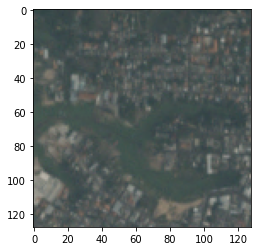

In [ ]:
# Basic testing of loaded dataset
plt.imshow(X_train[0])
op = get_tags_from_one_hot(y_train[0])
print(op)

##Defining some metrics for our model

In [ ]:
def metric_fbeta(y_true, y_pred, beta=2):
    y_pred = backend.clip(y_pred, 0, 1)
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    p = tp / (tp + fp + backend.epsilon())
    r = tp / (tp + fn + backend.epsilon())
    bb = beta ** 2
    fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
    return fbeta_score

In [ ]:
def precision_recall(y_true, y_pred):
    y_pred = backend.clip(y_pred, 0, 1)
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    p = tp / (tp + fp + backend.epsilon())
    r = tp / (tp + fn + backend.epsilon())
    p=backend.mean(p)
    r=backend.mean(r)
    return p,r

In [ ]:
def mean_accuracy(y_pred,y_test):
  true_array=[True for i in range(17)]
  train_acc=[]
  for i in range(len(y_pred)):
    correct=0
    for j in range(17):
      if y_pred[i][j]==y_test[i][j]:
        correct+=1
    train_acc.append(correct/17)
  return mean(train_acc)    

## Plotting learning curves for the model

In [ ]:
def summarize_diagnostics(history):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
    ax[0].set_title('Cross Entropy Loss')
    ax[0].plot(history['loss'], color='blue')
    ax[0].plot(history['val_loss'], color='orange')
    ax[0].legend(['train', 'test'], loc='upper left')
    ax[1].set_title('Fbeta')
    ax[1].plot(history['metric_fbeta'], color='blue')
    ax[1].plot(history['val_metric_fbeta'], color='orange')
    ax[1].legend(['train', 'test'], loc='upper left')
    plt.show()

## Generate iterators

In [ ]:
# function to perform image augmentation and return train and test iterators
def img_augmentation(X_train, y_train, X_test, y_test):
    train_datagen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, vertical_flip=True, rotation_range=90)
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    
    # prepare iterators
    train_it = train_datagen.flow(X_train, y_train, batch_size=128)
    test_it = test_datagen.flow(X_test, y_test, batch_size=128)
    
    return train_it, test_it

In [ ]:
# function to return train and test iterators
def generate_iterators(X_train, y_train, X_test, y_test):
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    
    train_it = datagen.flow(X_train, y_train, batch_size=128)
    test_it = datagen.flow(X_test, y_test, batch_size=128, shuffle=False)
    
    return train_it, test_it

## Saving the histories and predictions for plotting curves

In [ ]:
#function to save histories and predictions
def save_data(model_name, history, predictions):
  new_save_history_path = save_history_path + model_name + "_histories.json"
  new_save_predictions_path = save_predictions_path + model_name + "_predictions.pkl"

  history_dict = history.history
  json.dump(history_dict, open(new_save_history_path , 'w'))

  with open(new_save_predictions_path, 'wb') as file:
    pickle.dump(predictions, file)

In [ ]:
def model_predict(model, X_test, y_test):
  datagen = ImageDataGenerator(rescale=1.0/255.0)
  test_it = datagen.flow(X_test, y_test, batch_size=128, shuffle=False)
  predictions = model.predict(test_it, steps=len(test_it))
  return predictions

## Loading Models, Histories and Predictions

In [ ]:
def load_my_stuff(model_name):
  #loading the model
  keras.metrics.fbeta = metric_fbeta
  dependencies = {'metric_fbeta':metric_fbeta}
  model = load_model(save_model_path  + "saved_models/" + model_name + "/" + model_name +  ".h5", custom_objects=dependencies) 

  #loading the histories
  new_save_history_path = save_history_path + "saved_models/" + model_name + "/" + model_name  + "_histories.json"
  history_dict = json.load(open(new_save_history_path, 'r'))

  #loading the predictions
  new_save_predictions_path = save_predictions_path + "saved_models/" + model_name + "/" + model_name  + "_predictions.pkl"

  with open(new_save_predictions_path, 'rb') as file:
    preds = pickle.load(file)

  return model, history_dict, preds

## Get all the metrics for my loaded model

In [ ]:
def get_all_metrics(model_name, model, preds):

  pred_save_path = save_predictions_path + model_name + "_predictions.npy"
  
  preds_from_model = np.load(pred_save_path)


  fbeta_score_calc = metric_fbeta(y_test, preds_from_model, 2)
  fbeta_score_calc = fbeta_score_calc.numpy()
  fbeta_score_calc = fbeta_score_calc * 100
  fbeta_score_calc = round(fbeta_score_calc, 2)
  
  precision, recall = precision_recall(y_test, preds_from_model)
  precision = precision.numpy()
  recall = recall.numpy()
  precision = precision * 100
  precision = round(precision, 2)
  recall = recall * 100
  recall = round(recall, 2)

  clipped_preds=np.round(np.clip(preds_from_model,0,1))
  clipped_preds=clipped_preds.astype(int)
  mean_acc = mean_accuracy(clipped_preds, y_test)
  mean_acc = mean_acc * 100
  mean_acc = round(mean_acc, 2)
  
  print()
  print("Performance Metrics")
  print("F-beta score for your model is {}".format(fbeta_score_calc))
  print("Precision for your model is {}".format(precision))
  print("Recall for your model is {}".format(recall))
  print("Mean accuracy for your model is {}".format(mean_acc))

In [ ]:
def get_all_metrics_ensemble(y_test, preds):
  
  data = np.load("/content/drive/MyDrive/ensemble_predictions_full.npz")
  y_test = data['arr_0']
  preds_from_model = data['arr_1']
  y_test = y_test.astype(float)
  preds_from_model = preds_from_model.astype(float)
  fbeta_score_calc = metric_fbeta(y_test, preds_from_model, 2)
  fbeta_score_calc = fbeta_score_calc.numpy()
  fbeta_score_calc = fbeta_score_calc * 100
  fbeta_score_calc = round(fbeta_score_calc, 2)
  
  precision, recall = precision_recall(y_test, preds_from_model)
  precision = precision.numpy()
  recall = recall.numpy()
  precision = precision * 100
  precision = round(precision, 2)
  recall = recall * 100
  recall = round(recall, 2)

  clipped_preds=np.round(np.clip(preds_from_model,0,1))
  clipped_preds=clipped_preds.astype(int)
  mean_acc = mean_accuracy(clipped_preds, y_test)
  mean_acc = mean_acc * 100
  mean_acc = round(mean_acc, 2)
  
  print()
  print("Performance Metrics")
  print("F-beta score for your model is {}".format(fbeta_score_calc))
  print("Precision for your model is {}".format(precision))
  print("Recall for your model is {}".format(recall))
  print("Mean accuracy for your model is {}".format(mean_acc))

# CNN Models

## Base CNN Model

In [ ]:
def define_cnn_base_model(adam_opt, in_shape=(128, 128, 3), out_shape=17):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
      
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    
    model.add(Dense(out_shape, activation='sigmoid'))
    
    if adam_opt == True:
        opt = Adam()
    else:
        opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[metric_fbeta])
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       7

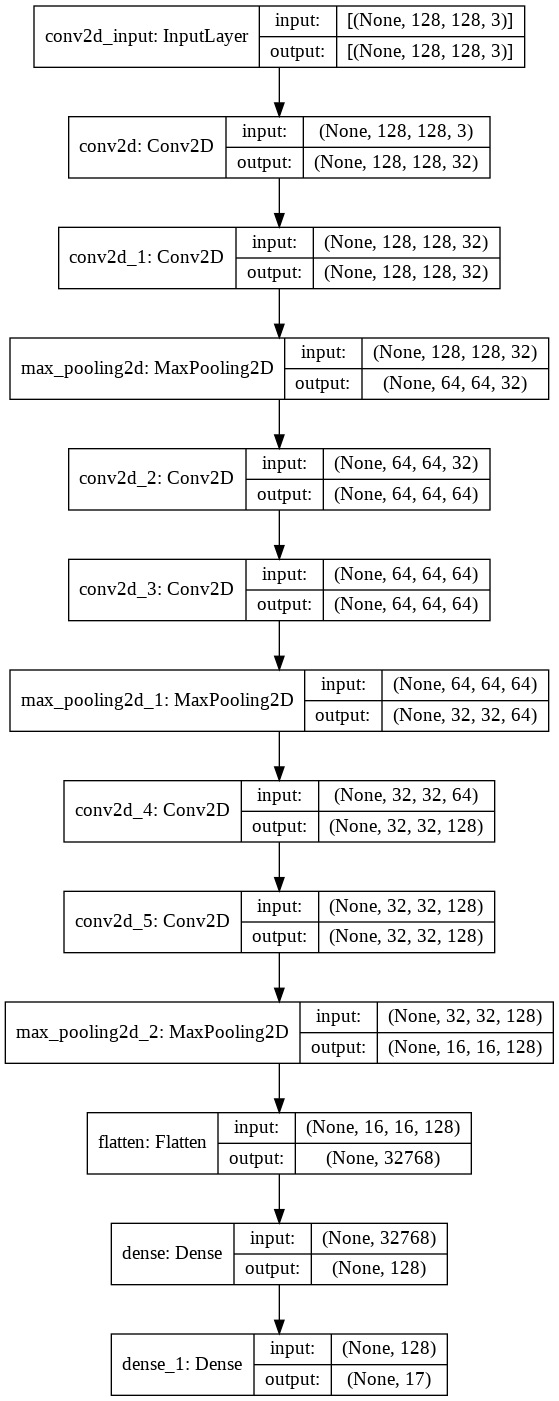

In [ ]:
for_summary = define_cnn_base_model(False)
for_summary.summary()
tf.keras.utils.plot_model(for_summary, show_shapes=True)

In [ ]:
def train_base_model(X_train, y_train, X_test, y_test, epochs, augment, adam_opt):
  if augment==True:
    model_name = "base_model_with_aug"
    train_it, test_it = img_augmentation(X_train, y_train, X_test, y_test)
  else:
    model_name = "base_model"
    train_it, test_it = generate_iterators(X_train, y_train, X_test, y_test)

  if adam_opt==True:
    model_name += "_adam_opt"

  #define model
  model =  define_cnn_base_model(adam_opt)

  #train model using train_data
  history = model.fit_generator(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=epochs, verbose=1)

  #evaluate trained model
  loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)
  print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))

  #save model trained
  new_path = save_model_path + model_name + ".h5"
  model.save(new_path)

  summarize_diagnostics(history.history)

  #get predictions from trained model
  predictions = model_predict(model, X_test, y_test)

  save_data(model_name, history, predictions)
    
  return model, history, predictions

In [ ]:
# base_preds_base_model = train_base_model(X_train, y_train, X_test, y_test, 10, True, True)

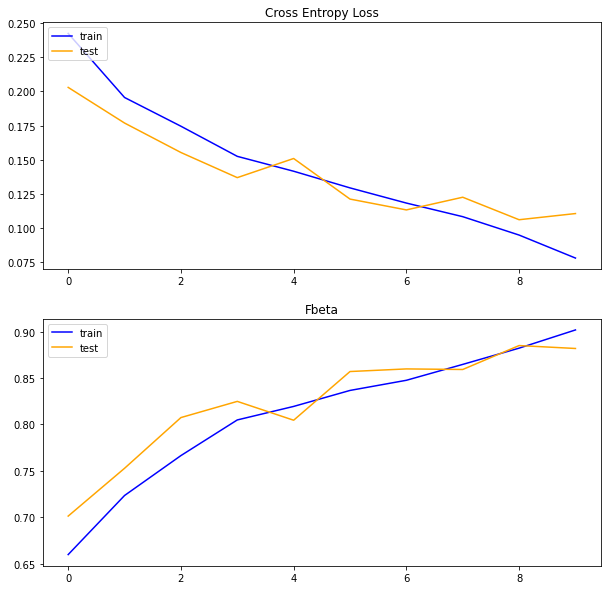


Performance Metrics
F-beta score for your model is 82.62
Precision for your model is 86.39
Recall for your model is 82.66
Mean accuracy for your model is 93.94


In [ ]:
loadedmodel, loadedhistory, loadedpreds = load_my_stuff("base_cnn_model_with_aug")
summarize_diagnostics(loadedhistory)
get_all_metrics("base_cnn_model_with_aug",loadedmodel, loadedpreds)

## Dropout Model

In [ ]:
# define cnn model
def define_dropout_model(adam_opt, in_shape=(128, 128, 3), out_shape=17):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    
    model.add(Dropout(0.5))
    
    model.add(Dense(out_shape, activation='sigmoid'))
    
    if adam_opt == True:
        opt = Adam()
    else:
        opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[metric_fbeta])
    
    return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)       

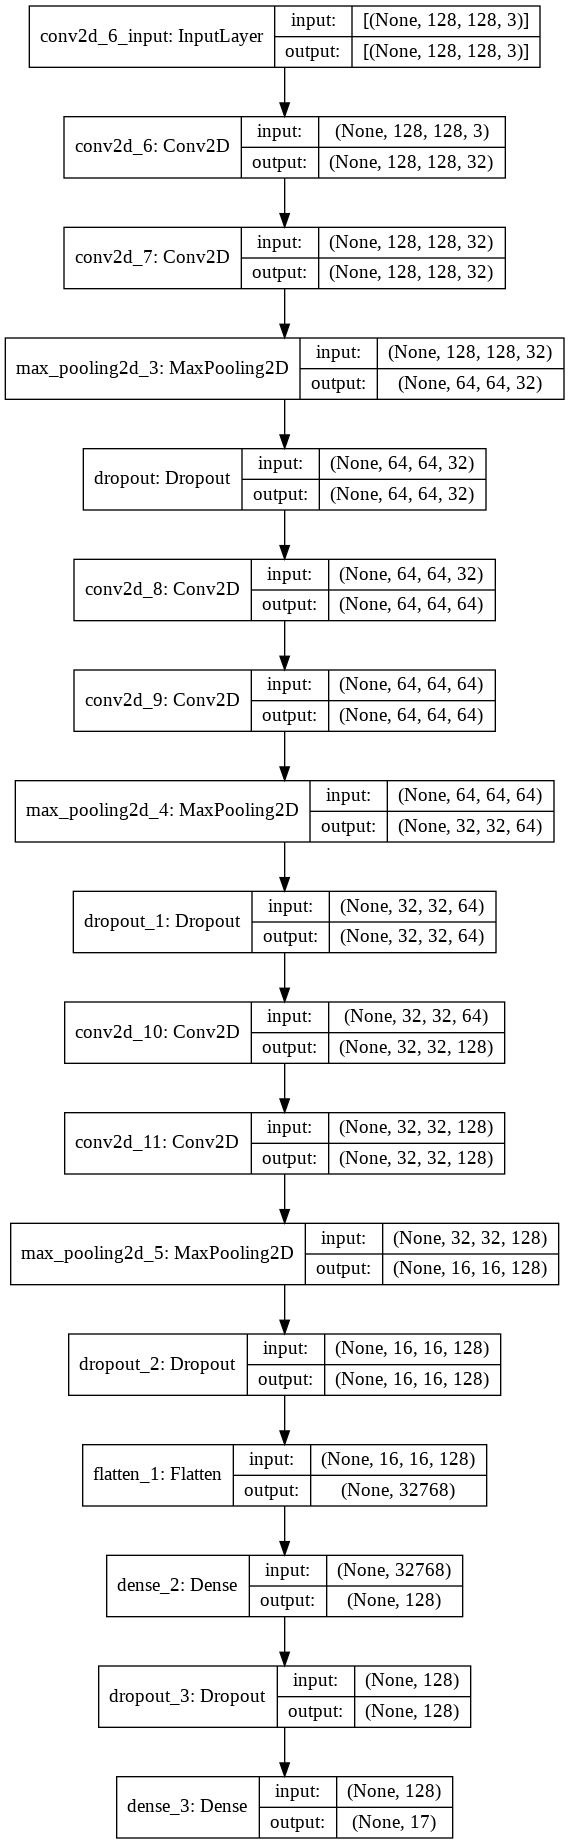

In [ ]:
for_summary = define_dropout_model(False)
for_summary.summary()
tf.keras.utils.plot_model(for_summary, show_shapes=True)

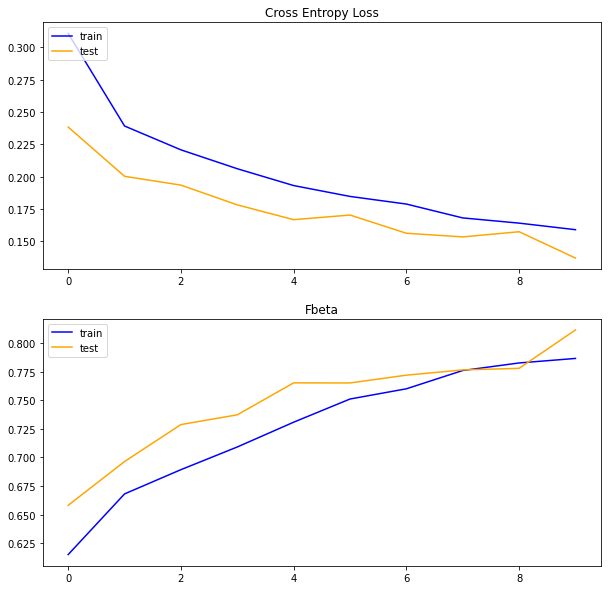


Performance Metrics
F-beta score for your model is 80.88
Precision for your model is 89.61
Recall for your model is 79.79
Mean accuracy for your model is 94.31


In [ ]:
loadedmodel, loadedhistory, loadedpreds = load_my_stuff("dropout_model_with_aug")
summarize_diagnostics(loadedhistory)
get_all_metrics("dropout_model_with_aug", loadedmodel, loadedpreds)

## VGG-16 Model with certain layers frozen

In [ ]:
def define_transfer_model(adam_opt, in_shape=(128, 128, 3), out_shape=17):
    # load model
    model = VGG16(include_top=False, input_shape=in_shape)
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(out_shape, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    if adam_opt==True:
      opt = Adam()
    else:
      opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[metric_fbeta])
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

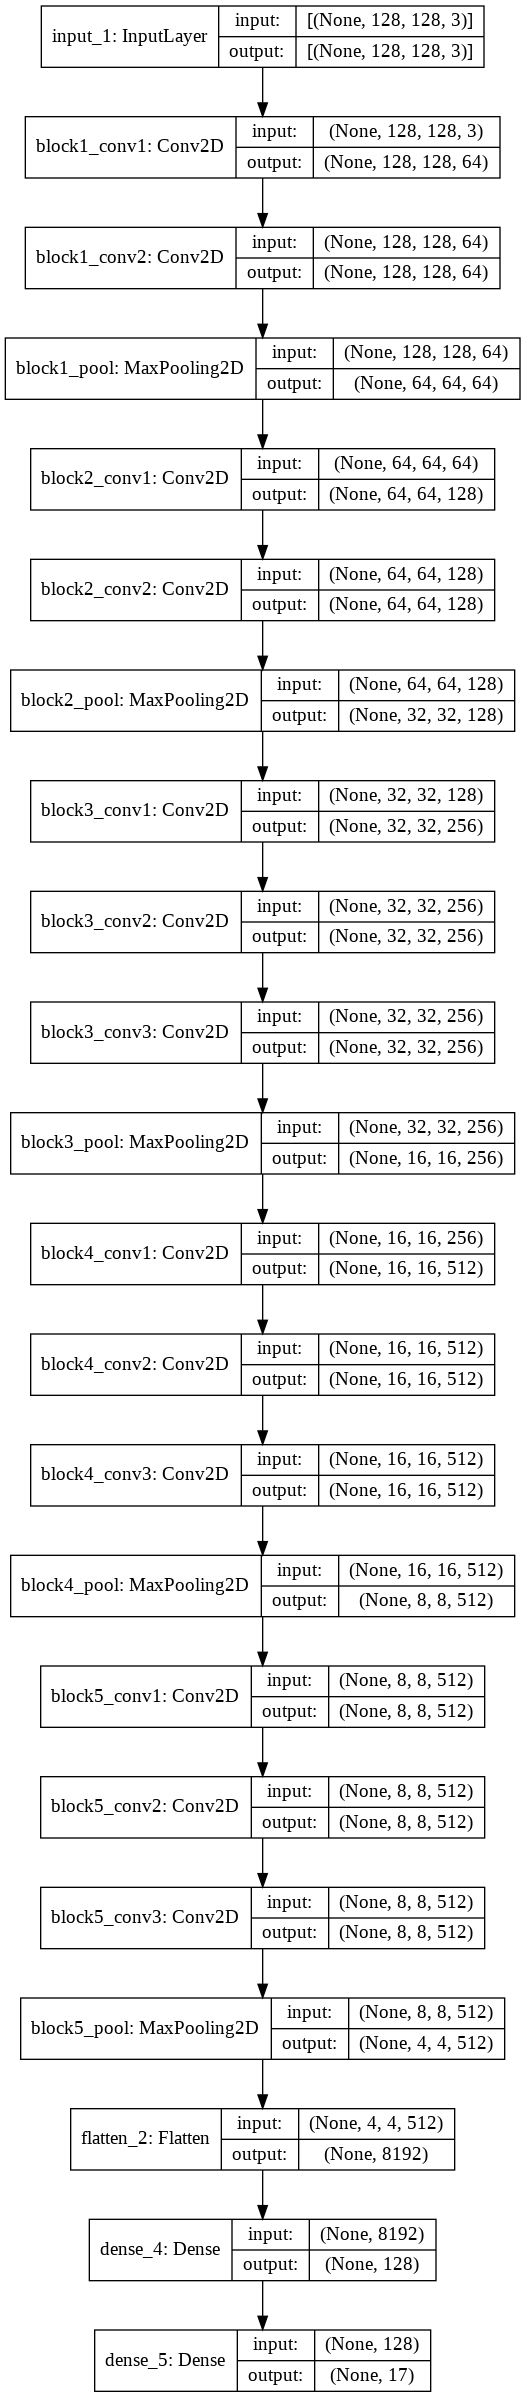

In [ ]:
for_summary = define_transfer_model(False)
for_summary.summary()
tf.keras.utils.plot_model(for_summary, show_shapes=True)

In [ ]:
def train_transfer_model(X_train, y_train, X_test, y_test, epochs, augment, adam_opt):
  if augment==True:
    model_name = "transfer_model_with_aug"
    train_it, test_it = img_augmentation(X_train, y_train, X_test, y_test)
  else:
    model_name = "transfer_model"
    train_it, test_it = generate_iterators(X_train, y_train, X_test, y_test)

  if adam_opt==True:
    model_name += "_adam_opt"

  #define model
  model =  define_transfer_model(adam_opt)

  #train model using train_data
  history = model.fit_generator(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=epochs, verbose=1)

  #evaluate trained model
  loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)
  print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))

  #save model trained
  new_path = save_model_path + model_name + ".h5"
  model.save(new_path)

  summarize_diagnostics(history.history)

  #get predictions from trained model
  predictions = model_predict(model, X_test, y_test)

  save_data(model_name, history, predictions)
    
  return model, history, predictions

In [ ]:
# preds_transfer_model = train_transfer_model(X_train, y_train, X_test, y_test, 30, True, True )

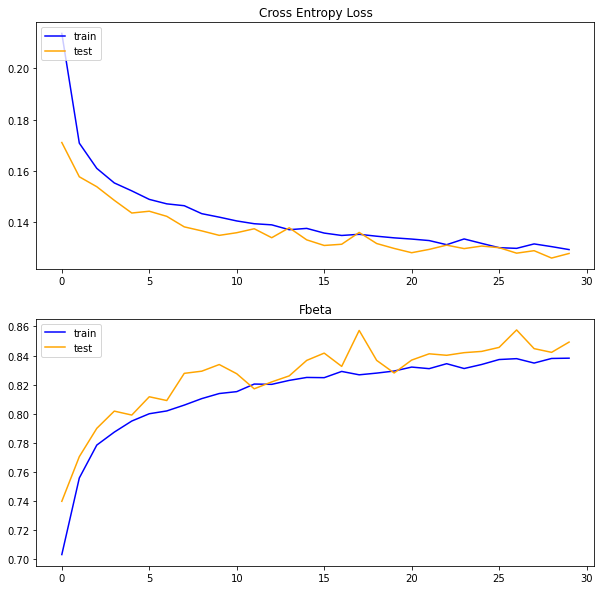


Performance Metrics
F-beta score for your model is 84.93
Precision for your model is 89.74
Recall for your model is 84.65
Mean accuracy for your model is 95.05


In [ ]:
loadedmodel, loadedhistory, loadedpreds = load_my_stuff("transfer_model_with_aug_adam_opt")
summarize_diagnostics(loadedhistory)
get_all_metrics("transfer_model_with_aug_adam_opt", loadedmodel, loadedpreds)

## ResNet-50 concatenated with Base Model

In [ ]:
def define_transfer_model_resnet(adam_opt, in_shape=(128, 128, 3), out_shape=17):
    resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(128,128,3))
    return resnet

In [ ]:
def define_concatenated_resnet(adam_opt, in_shape=(128, 128, 3), out_shape=17):
  restnet = define_transfer_model_resnet(False)
  model = Sequential()
  model.add(restnet)
  model.add(Flatten())
  model.add(Dense(512, activation='relu', input_dim=(128, 128, 3)))
  model.add(Dropout(0.3))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(17, activation='sigmoid'))
  if adam_opt==True:
    opt = Adam()
  else:
    opt = SGD(lr=0.01, momentum=0.9)
  model.compile(loss='binary_crossentropy',
                optimizer=optimizers.RMSprop(lr=2e-5),
                metrics=[metric_fbeta])
  return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               16777728  
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 17)               

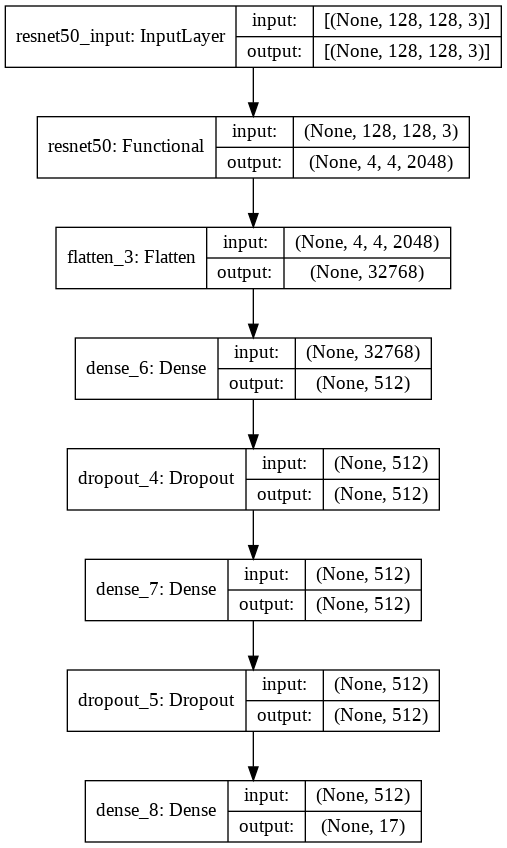

In [ ]:
for_summary = define_concatenated_resnet(False)
for_summary.summary()
tf.keras.utils.plot_model(for_summary, show_shapes=True)

In [ ]:
def train_resnet_concatenated(X_train, y_train, X_test, y_test, epochs, augment, adam_opt):
  if augment==True:
    model_name = "resnet_conc_model_with_aug"
    train_it, test_it = img_augmentation(X_train, y_train, X_test, y_test)
  else:
    model_name = "resnet_conc_model"
    train_it, test_it = generate_iterators(X_train, y_train, X_test, y_test)

  if adam_opt==True:
    model_name += "_adam_opt"

  #define model
  model =  define_concatenated_resnet(adam_opt)

  #train model using train_data
  history = model.fit_generator(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=epochs, verbose=1)

  #evaluate trained model
  loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)
  print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))

  #save model trained
  new_path = save_model_path + model_name + ".h5"
  model.save(new_path)

  summarize_diagnostics(history.history)

  #get predictions from trained model
  predictions = model_predict(model, X_test, y_test)

  save_data(model_name, history, predictions)
    
  return model, history, predictions

In [ ]:
# preds_transfer_model_resnet = train_resnet_concatenated(X_train, y_train, X_test, y_test, 10, True, True )

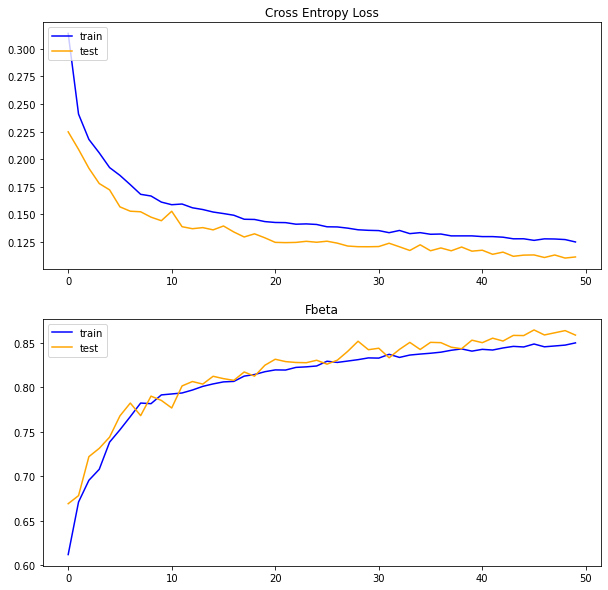


Performance Metrics
F-beta score for your model is 85.85
Precision for your model is 92.31
Recall for your model is 85.09
Mean accuracy for your model is 95.63


In [ ]:
loadedmodel, loadedhistory, loadedpreds = load_my_stuff("resnet50_concatenated_model")
summarize_diagnostics(loadedhistory)
get_all_metrics("resnet50_concatenated_model", loadedmodel, loadedpreds)

##VGG-16 Merged with Base Model

In [ ]:
def define_transfer_model_vgg16(adam_opt, in_shape=(128, 128, 3), out_shape=17):
    # load model
    model=Sequential()
    model.add(VGG16(include_top=False, input_shape=in_shape))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(17, activation='softmax'))
    if adam_opt == True:
      opt = Adam()
    else:
      opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[metric_fbeta])
    return model

In [ ]:
def define_vgg16_conc_model():
  model_1=define_transfer_model_vgg16(True)    
  model_2=define_cnn_base_model(True)    
  concatenated = concatenate([model_1.output, model_2.output])
  concatenated_final = Dense(17, activation='sigmoid')(concatenated)
  model_final =  Model(inputs=[model_1.input,model_2.input], outputs=concatenated_final, name='Final_output')
  model_final.compile(optimizer='adam', loss='binary_crossentropy',metrics=[metric_fbeta])
  return model_final

Model: "Final_output"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_12_input (InputLayer)    [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 128, 128, 32) 896         conv2d_12_input[0][0]            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 128, 128, 32) 9248        conv2d_12[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 64, 64, 32)   0           conv2d_13[0][0]                  
_______________________________________________________________________________________

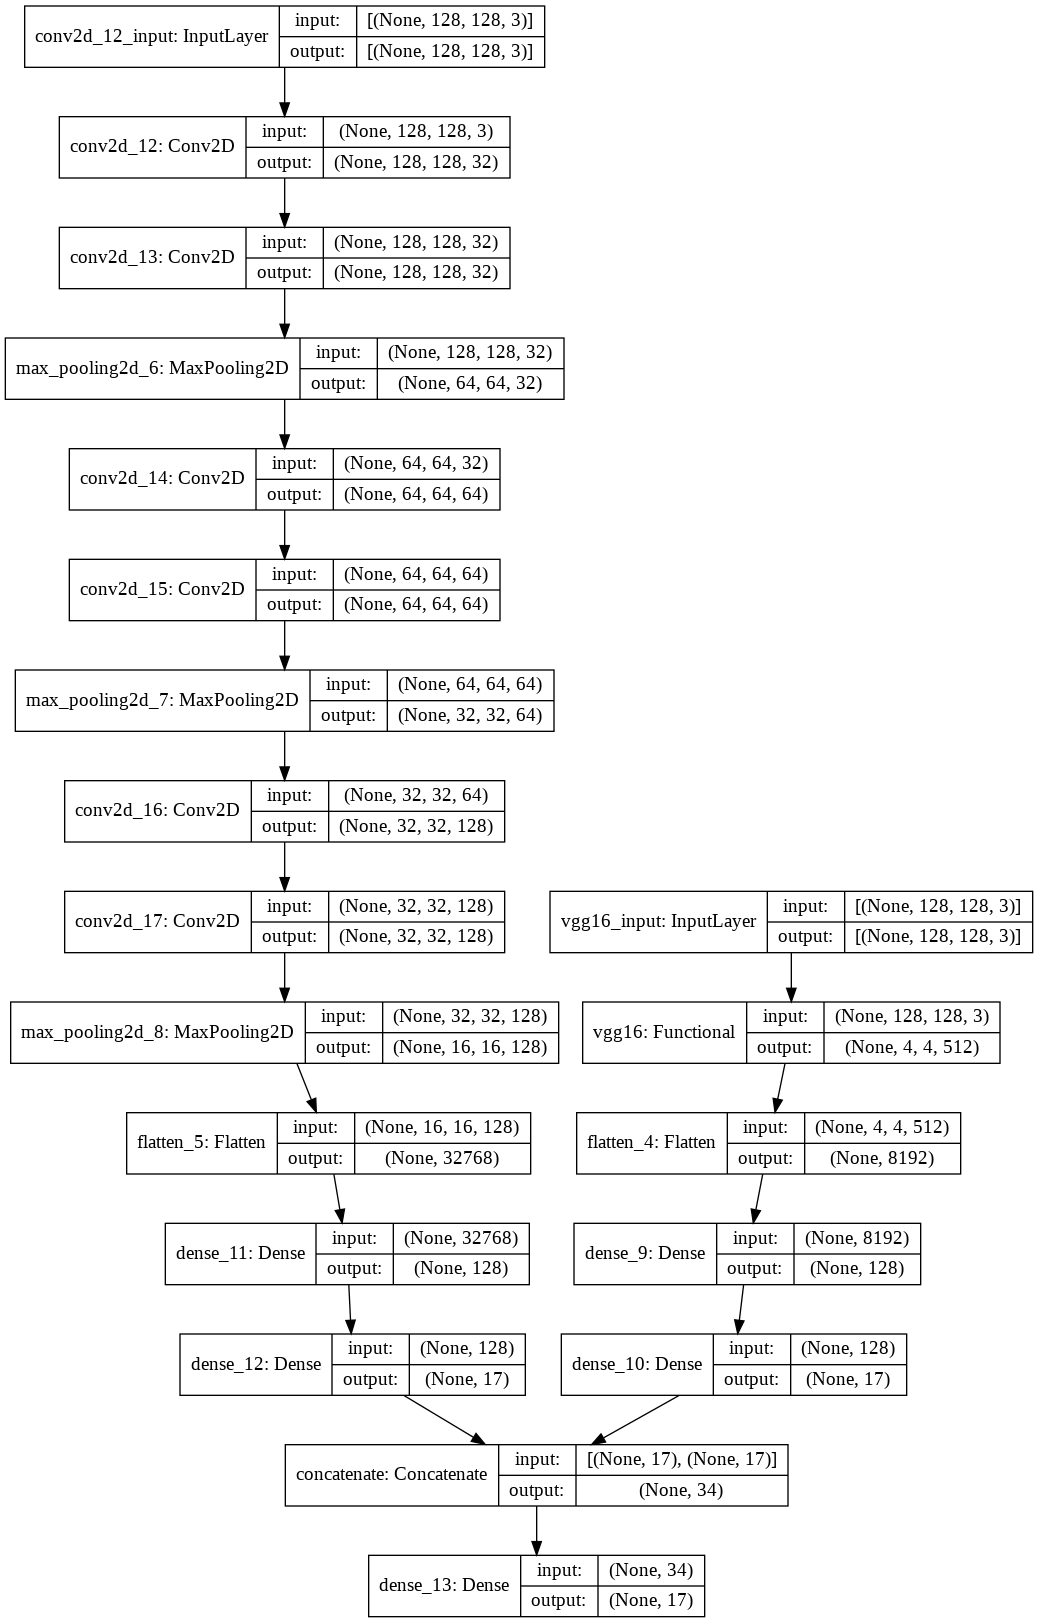

In [ ]:
for_summary = define_vgg16_conc_model()
for_summary.summary()
tf.keras.utils.plot_model(for_summary, show_shapes=True)

In [ ]:
def train_vgg16_conc_model(X_train, y_train, X_test, y_test, epochs, augment, adam_opt):
  if augment==True:
    model_name = "vgg16_conc_model"

  if adam_opt==True:
    model_name += "_adam_opt"

  #define model
  model =  define_vgg16_conc_model()

  #train model using train_data
  history=model.fit(x=[X_train,X_train], y=y_train, validation_data=([X_test,X_test], y_test), epochs=10, batch_size=128)


  #evaluate trained model
  loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)
  print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))

  #save model trained
  new_path = save_model_path + model_name + ".h5"
  model.save(new_path)

  summarize_diagnostics(history.history)

  #get predictions from trained model
  predictions = model_predict(model, X_test, y_test)

  save_data(model_name, history, predictions)
    
  return model, history, predictions

In [ ]:
# preds_vgg_conc_model_resnet = train_vgg16_conc_model(X_train, y_train, X_test, y_test, 25, False, True )

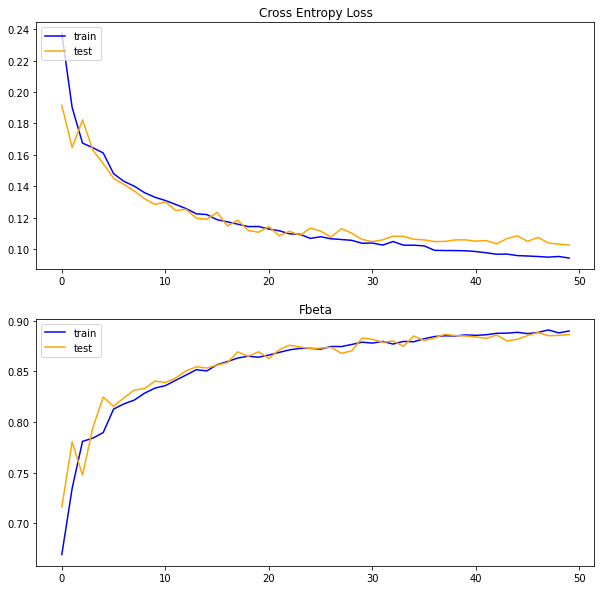


Performance Metrics
F-beta score for your model is 88.62
Precision for your model is 91.66
Recall for your model is 88.53
Mean accuracy for your model is 96.12


In [ ]:
loadedmodel, loadedhistory, loadedpreds = load_my_stuff("vgg16_concatenated_model")
summarize_diagnostics(loadedhistory)
get_all_metrics("vgg16_concatenated_model", loadedmodel, loadedpreds)

## Ensemble Learning Model 

In [ ]:
# train_datagen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, vertical_flip=True, rotation_range=90)
# test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# test_it = test_datagen.flow(X_test, y_test)

In [ ]:
def train_base_model_bagging(model_name, train_it, test_it, epochs, augment, adam_opt):

  model =  define_cnn_base_model(adam_opt)


  history = model.fit_generator(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=epochs, verbose=1)


  loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)

  new_path = save_model_path + model_name + ".h5"
  model.save(new_path)   
  return model

In [ ]:
def bagging_base_models(k_val, X_train, y_train, test_input_val):
  model_preds = []
  for iter_no in range(k_val):
    #sampling the dataset with replacement
    di_size = len(X_train) // k_val
    if di_size <= 1:
      print("Your k-val is too small")
      break
    X_i = []
    y_i = []
    for i in range(di_size):
      random_gen = randint(0, len(X_train)-1)
      X_i.append(X_train[random_gen])
      y_i.append(y_train[random_gen])
  
    #training the base cnn model
    X_i = np.array(X_i)
    y_i = np.array(y_i)
    print(X_i.shape)
    print(y_i.shape)
    print("Training model " + str(iter_no+1))
    model_name = "base_model_bagging_" + str(iter_no + 1)
    train_it = train_datagen.flow(X_i, y_i)
    model = train_base_model_bagging(model_name, train_it, test_it, 10, True, True)

    #testing the model on a given example
    test_input_val = np.reshape(test_input_val, [1, 128, 128, 3])
    test_input_val = test_input_val  / 255

    preds = model.predict(test_input_val)
    preds = np.round(np.clip(preds,0,1))
    preds=preds.astype(int) 

    model_preds.append(preds)

  return model_preds

In [ ]:
# outputs = bagging_base_models(5, X_train, y_train, X_test[12])

In [ ]:
def get_predictions(model, test_input_val):
    test_input_val = np.reshape(test_input_val, [1, 128, 128, 3])
    test_input_val = test_input_val  / 255
    preds = model(test_input_val)
    preds = np.round(np.clip(preds,0,1))
    preds=preds.astype(int) 
    return preds

In [ ]:
def get_final_output(outputs):
  final_op = []
  outputs_cleaned = [outputs[i][0] for i in range(len(outputs))]
  for i in range(17):
    zero_cnt = 0
    one_cnt = 0
    for op in outputs_cleaned:
      if op[i] == 0:
        zero_cnt += 1
      else:
        one_cnt += 1
    if zero_cnt > one_cnt:
      final_op.append(0)
    else:
      final_op.append(1)
  return final_op

In [ ]:
def get_ensemble_output(k):
  final_outputs = []
  for i in range(len(X_test)-5000):
    print("Training example: " + str(i+1))
    outputs = []
    test_input_val = X_test[i]
    for j in range(1, k+1):
      path_val = "/content/drive/MyDrive/ensemble_model/base_model_bagging_" + str(j) + ".h5"
      keras.metrics.fbeta = metric_fbeta
      dependencies = {'metric_fbeta':metric_fbeta}
      model = load_model(path_val, custom_objects=dependencies) 
      pred = get_predictions(model, test_input_val)
      outputs.append(pred)
    cleaned_op = get_final_output(outputs)
    final_outputs.append(cleaned_op)
  return final_outputs

In [ ]:
#Evaluate the ensemble model
def test_ensemble_model():
  final_outputs = get_ensemble_output(5)
  final_outputs = np.array(final_outputs)
  final_outputs = final_outputs.astype(float)
  get_all_metrics_ensemble(y_test, final_outputs)

In [ ]:
get_all_metrics_ensemble(_, _)


Performance Metrics
F-beta score for your model is 93.74
Precision for your model is 90.25
Recall for your model is 95.67
Mean accuracy for your model is 97.41


In [ ]:
#Testing the Ensemble Model on an Input Image
def ensemble_on_input_image(img, k, actual_tag):
    plt.imshow(img,cmap=plt.cm.gray, origin='centre',extent=(0,1600,0,1200))
    print()
    print("Actual tags: " + str(get_tags_from_one_hot(actual_tag)))
    print()
    outputs = []
    test_input_val = img
    for j in range(1, k+1):
      path_val = "/content/drive/MyDrive/ensemble_model/base_model_bagging_" + str(j) + ".h5"
      keras.metrics.fbeta = metric_fbeta
      dependencies = {'metric_fbeta':metric_fbeta}
      model = load_model(path_val, custom_objects=dependencies) 
      pred = get_predictions(model, test_input_val)
      outputs.append(pred)
    print("Predictions from Models: ")
    print("Model 1: " + str(outputs[0][0]))
    print("Model 2: " + str(outputs[1][0]))
    print("Model 3: " + str(outputs[2][0]))
    print("Model 4: " + str(outputs[3][0]))
    print("Model 5: " + str(outputs[4][0]))

    cleaned_op = get_final_output(outputs)
    print()
    print("Final output predicted by the ensemble model using majority rule is " + str(cleaned_op))
    print("Output: " + str(get_tags_from_one_hot(cleaned_op)))
    error_val = np.linalg.norm(cleaned_op - actual_tag)
    print()
    print("Error is " + str(error_val))
    print()
    print("image: ")


Actual tags: ['clear', 'primary']

Predictions from Models: 
Model 1: [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
Model 2: [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
Model 3: [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
Model 4: [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
Model 5: [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]

Final output predicted by the ensemble model using majority rule is [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Output: ['clear', 'primary']

Error is 0.0

image: 


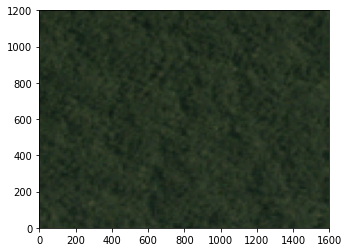

In [ ]:
ensemble_on_input_image(X_test[78], 5, y_test[78])

# Comparing all the models seen till now

In [ ]:
precision_vals = [86.39, 89.61, 89.74, 92.31, 91.66, 90.25]
recall_vals = [82.66, 79.79, 84.65, 85.09, 88.53, 95.67]
fbeta_vals = [82.62, 80.88, 84.93, 85.85, 88.62, 93.74]
mean_accuracy_vals = [93.94, 94.31, 95.05, 95.63, 96.12, 97.41]
models = ['Base CNN','Dropout CNN','VGG-16 Transfer Model','Custom Model-1 Resnet and Base CNN', 'Custom Model-2 VGG-16 and Base CNN', 'Ensemble Model']
dashboard = {'Precision': precision_vals,'Recall': recall_vals, 'F-beta':fbeta_vals, "Mean Accuracy":mean_accuracy_vals}
df = pd.DataFrame(dashboard, columns = ['Precision', 'Recall', 'F-beta', 'Mean Accuracy'], index=['Base CNN','Dropout CNN','VGG-16 Transfer Model','Custom Model-1 Resnet and Base CNN', 'Custom Model-2 VGG-16 and Base CNN', 'Ensemble Model'])

In [ ]:
df

,Precision,Recall,F-beta,Mean Accuracy
Base CNN,86.39,82.66,82.62,93.94
Dropout CNN,89.61,79.79,80.88,94.31
VGG-16 Transfer Model,89.74,84.65,84.93,95.05
Custom Model-1 Resnet and Base CNN,92.31,85.09,85.85,95.63
Custom Model-2 VGG-16 and Base CNN,91.66,88.53,88.62,96.12
Ensemble Model,90.25,95.67,93.74,97.41


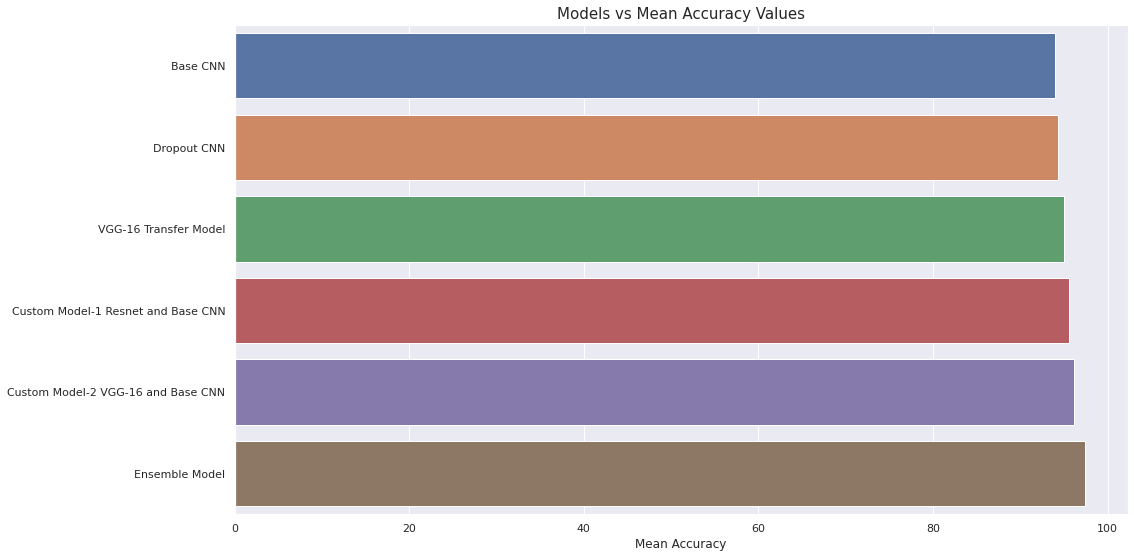

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
y_vals = df.index.to_series()
x_vals = df['Mean Accuracy']
plt.figure(figsize=(16,9))
sns.barplot(x=x_vals, y=y_vals)
plt.title('Models vs Mean Accuracy Values', size=15)
plt.show()